In [ ]:
# Author: Roi Yehoshua
# Date: January 2024
# MIT License

# Based on the PyTorch implementation from https://nlp.seas.harvard.edu/annotated-transformer/

In [ ]:
# Make sure you have the following packages installed:
!pip install spacy portalocker --quiet
!pip install torch==2.0.0 torchtext==0.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import spacy
import os

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
torch.manual_seed(42)  # For reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

device(type='cuda')

### Multi-Head Attention

$$
    \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O \\
    \text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) \\  
    \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

In [ ]:
class MultiHeadAttention(nn.Module):
    """The multi-head attention module"""
    def __init__(self, d_model, num_heads):
        super().__init__()

        # Ensure the dimension of the model is divisible by the number of heads.
        # This is necessary to equally divide the embedding dimension across heads.
        assert d_model % num_heads == 0, 'd_model must be divisible by num_heads'

        self.d_model = d_model           # Total dimension of the model
        self.num_heads = num_heads       # Number of attention heads
        self.d_k = d_model // num_heads  # Dimnsion of each head. We assume d_v = d_k

        # Linear transformations for queries, keys, and values
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Final linear layer to project the concatenated heads' outputs back to d_model dimensions
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # 1. Calculate attention scores with scaling
        # Q shape: [batch_size, num_heads, seq_length_q, d_k]
        # K shape: [batch_size, num_heads, seq_length_k, d_k]
        # V shape: [batch_size, num_heads, seq_length_v, d_k]

        # Compute attention scores
        # K.transpose(-2, -1) changes K from [batch, heads, seq_len, d_k] to [batch, heads, d_k, seq_len]
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # 2. Apply mask (if provided) by setting masked positions to a large negative value
        if mask is not None:
            # mask shape should be broadcastable to scores shape
            scores = scores.masked_fill(mask == 0, -1e9)

        # 3. Apply softmax to attention scores to get probabilities
        attention_weights = F.softmax(scores, dim=-1)

        # 4. Return the weighted sum of values based on attention probabilities
        output = torch.matmul(attention_weights, V)

        return output

    def split_heads(self, x):
        # Reshape the input tensor to [batch_size, num_heads, seq_length, d_k]
        # to prepare for multi-head attention processing
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Inverse operation of split_heads: combine the head outputs back into the original tensor shape
        # [batch_size, seq_length, d_model]
        batch_size, num_heads, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        ### WRITE YOUR CODE HERE

        # 1. Linearly project the queries, keys, and values, and then split them into heads.
        # 2. Apply scaled dot-product attention for each head.
        # 3. Concatenate the heads' outputs and apply the final linear projection.

        # 1. Linearly project the queries, keys, and values
        Q = self.W_q(Q)  # [batch_size, seq_length, d_model]
        K = self.W_k(K)  # [batch_size, seq_length, d_model]
        V = self.W_v(V)  # [batch_size, seq_length, d_model]

        # Split them into heads
        Q = self.split_heads(Q)  # [batch_size, num_heads, seq_length, d_k]
        K = self.split_heads(K)  # [batch_size, num_heads, seq_length, d_k]
        V = self.split_heads(V)  # [batch_size, num_heads, seq_length, d_k]

        # 2. Apply scaled dot-product attention for each head
        attention_output = self.scaled_dot_product_attention(Q, K, V, mask)
        # attention_output shape: [batch_size, num_heads, seq_length, d_k]

        # 3. Concatenate the heads' outputs
        attention_output = self.combine_heads(attention_output)
        # attention_output shape: [batch_size, seq_length, d_model]

        # Apply the final linear projection
        output = self.W_o(attention_output)
        # output shape: [batch_size, seq_length, d_model]

        return output

### Feed-Forward NN

$$
    \text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
$$

In [ ]:
class PositionwiseFeedForward(nn.Module):
    """The Positionwise Feedforward Network (FFN) module"""
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)

        return x


### Positional Encoding

$$
    \text{PE}(pos, 2i) = \sin(pos/10000^{2i/d_{\text{model}}}) \\
    \text{PE}(pos, 2i + 1) = \cos(pos/10000^{2i/d_{\text{model}}})
$$

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Implements the positional encoding module using sinusoidal functions of different frequencies
    for each dimension of the encoding.
    """
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        # Create a positional encoding (PE) matrix with dimensions [max_seq_length, d_model].
        # This matrix will contain the positional encodings for all possible positions up to max_seq_length.
        pe = torch.zeros(max_seq_length, d_model)

        # Generate a tensor of positions (0 to max_seq_length - 1) and reshape it to [max_seq_length, 1].
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)

        # Compute the division term used in the formulas for sin and cos functions.
        # This term is based on the dimension of the model and the position, ensuring that the wavelengths
        # form a geometric progression from 2π to 10000 * 2π. It uses only even indices for the dimensions.
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply the sin function to even indices in the PE matrix. These values are determined by
        # multiplying the position by the division term, creating a pattern where each position has
        # a unique sinusoidal encoding.
        pe[:, 0::2] = torch.sin(position * div_term)

        # Apply the cos function to odd indices in the PE matrix, complementing the sin-encoded positions.
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register 'pe' as a buffer within the module. Unlike parameters, buffers are not updated during training.
        # This is crucial because positional encodings are fixed and not subject to training updates.
        # The unsqueeze(0) adds a batch dimension for easier broadcasting with input tensors.
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Add positional encoding to the input tensor x.
        # x is expected to have dimensions [batch_size, seq_length, d_model].
        # The positional encoding 'pe' is sliced to match the seq_length of 'x', and then added to 'x'.
        # This operation leverages broadcasting to apply the same positional encoding across the batch.
        x = x + self.pe[:, :x.size(1)]
        return x

### Encoder Layer

In [ ]:
class EncoderLayer(nn.Module):
    """An encoder layer consists of a multi-head self-attention sublayer and a feed forward sublayer,
       with a dropout, residual connection, and layer normalization after each sub-layer.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Frank
        # Self-attention sublayer with residual connection and layer norm
        # Store residual
        residual = x

        # Apply self-attention
        attn_output = self.self_attn(x, x, x, mask)

        # Apply dropout
        attn_output = self.dropout(attn_output)

        # Add residual connection
        x = residual + attn_output

        # Apply layer normalization
        x = self.layer_norm1(x)

        # Feed-forward sublayer with residual connection and layer norm
        # Store residual
        residual = x

        # Apply feed-forward network
        ff_output = self.feed_forward(x)

        # Apply dropout
        ff_output = self.dropout(ff_output)

        # Add residual connection
        x = residual + ff_output

        # Apply layer normalization
        x = self.layer_norm2(x)

        return x

### Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
    """A decoder layer consists of a multi-head self-attention, cross-attention and a feed-forward sublayers,
       with a dropout, residual connection, and layer normalization after each sub-layer.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.layer_norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Self-attention sublayer with residual connection and layer norm
        # Store residual
        residual = x

        # Apply self-attention (masked)
        self_attn_output = self.self_attn(x, x, x, tgt_mask)

        # Apply dropout
        self_attn_output = self.dropout(self_attn_output)

        # Add residual connection
        x = residual + self_attn_output

        # Apply layer normalization
        x = self.layer_norm1(x)

        # Cross-attention sublayer with residual connection and layer norm
        # Store residual
        residual = x

        # Apply cross-attention (query from decoder, key/value from encoder)
        cross_attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)

        # Apply dropout
        cross_attn_output = self.dropout(cross_attn_output)

        # Add residual connection
        x = residual + cross_attn_output

        # Apply layer normalization
        x = self.layer_norm2(x)

        # Feed-forward sublayer with residual connection and layer norm
        # Store residual
        residual = x

        # Apply feed-forward network
        ff_output = self.feed_forward(x)

        # Apply dropout
        ff_output = self.dropout(ff_output)

        # Add residual connection
        x = residual + ff_output

        # Apply layer normalization
        x = self.layer_norm3(x)

        return x

### The Full Model

In [ ]:
class Transformer(nn.Module):
    """
    Implements the Transformer model for sequence-to-sequence tasks such as machine translation.
    The Transformer model, as described in "Attention is All You Need" by Vaswani et al., consists of an encoder and
    decoder architecture that uses self-attention mechanisms to process input sequences and generate output sequences.

    Parameters:
    - src_vocab_size (int): Size of the source vocabulary.
    - tgt_vocab_size (int): Size of the target vocabulary.
    - d_model (int): Dimension of the model embeddings and hidden states.
    - N (int): Number of layers in both the encoder and decoder stacks.
    - n_heads (int): Number of attention heads in each multi-head attention mechanism.
    - d_ff (int): Dimension of the feed-forward network within each layer.
    - max_seq_length (int): Maximum length of input sequences, used for positional encoding.
    - dropout (float): Dropout rate applied to embeddings and sub-layers.
    - pad_idx (int): Index of the padding token in the source and target vocabularies.

    Attributes:
    - src_embedding (torch.nn.Embedding): Embedding layer for source sequences.
    - tgt_embedding (torch.nn.Embedding): Embedding layer for target sequences.
    - positional_encoding (PositionalEncoding): Adds positional information to embeddings.
    - encoder (torch.nn.ModuleList): Stack of N encoder layers.
    - decoder (torch.nn.ModuleList): Stack of N decoder layers.
    - out (torch.nn.Linear): Linear layer that projects decoder output to target vocabulary size.
    - dropout (torch.nn.Dropout): Dropout layer applied after embedding and positional encoding.

    Methods:
    - init_weights: Initializes model parameters using Glorot uniform initialization.
    - create_source_mask: Creates a mask for padding tokens in the source sequence to ignore them in attention computations.
    - create_target_mask: Creates combined padding and future token masks for the target sequence to prevent attending to future tokens and padding tokens.
    - encode: Processes the source sequence through the encoder stack and generates memory states.
    - decode: Processes the target sequence through the decoder stack using memory states from the encoder and applicable masks.
    - forward: Defines the forward pass of the model using the encode and decode methods.
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, N, n_heads, d_ff, max_seq_length, dropout, pad_idx):
        super().__init__()

        # Embedding layers for source and target
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # Encoder and Decoder stacks
        self.encoder = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(N)])
        self.decoder = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(N)])

        # Output linear layer
        self.out = nn.Linear(d_model, tgt_vocab_size)

        self.dropout = nn.Dropout(dropout)

        # Initialization
        self.init_weights()
        self.pad_idx = pad_idx

    def init_weights(self):
        """Initialize parameters with Glorot / fan_avg"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def create_source_mask(self, src):
        """Create a mask for padding tokens in the source"""
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, src_len]
        # unsqueeze(1) adds a dimension for the heads of the multi-head attention
        # unsqueeze(2) adds a dimension for the attention scores
        # This mask can be broadcasted across the src_len dimension of the attention scores,
        # effectively masking out specific tokens across all heads and all positions in the sequence.
        return src_mask

    def create_target_mask(self, tgt):
        """Create masks for both padding tokens and future tokens"""
        # Target padding mask
        tgt_pad_mask = (tgt != self.pad_idx).unsqueeze(1).unsqueeze(3)  # [batch_size, 1, tgt_len, 1]
        # unsqueeze(1) adds a dimension for the heads of the multi-head attention
        # unsqueeze(3) adds a dimension for the attention scores
        # The final shape allows the mask to be broadcast across the attention scores, ensuring positions only
        # attend to allowed positions as dictated by the no-peak mask (the preceding positions) and the padding mask.

        # Target no-peak mask
        tgt_len = tgt.size(1)
        tgt_nopeak_mask = torch.tril(torch.ones(tgt_len, tgt_len, device=device)).bool()

        # Combine masks
        tgt_mask = tgt_pad_mask & tgt_nopeak_mask  # [batch_size, 1, tgt_len, tgt_len]
        return tgt_mask

    def encode(self, src):
        """Encodes the source sequence using the Transformer encoder stack.
        """
        src_mask = self.create_source_mask(src)
        src = self.dropout(self.positional_encoding(self.src_embedding(src)))

        # Pass through each layer in the encoder
        for layer in self.encoder:
            src = layer(src, src_mask)
        return src, src_mask

    def decode(self, tgt, memory, src_mask):
        """Decodes the target sequence using the Transformer decoder stack, given the memory from the encoder.
        """
        tgt_mask = self.create_target_mask(tgt)
        tgt = self.dropout(self.positional_encoding(self.tgt_embedding(tgt)))

        # Pass through each layer in the decoder
        for layer in self.decoder:
            tgt = layer(tgt, memory, src_mask, tgt_mask)

        # Output layer
        output = self.out(tgt)
        return output

    def forward(self, src, tgt):
        # Encode the source sequence
        memory, src_mask = self.encode(src)

        # Decode the target sequence using the encoder's output
        output = self.decode(tgt, memory, src_mask)

        return output

In [ ]:
# Define the hyperparameters of the model
src_vocab_size = 5000  # Size of source vocabulary
tgt_vocab_size = 5000  # Size of target vocabulary
d_model = 512          # Embedding dimension
N = 6                  # Number of encoder and decoder layers
num_heads = 8          # Number of attention heads
d_ff = 2048            # Dimension of feed forward networks
max_seq_length = 100   # Maximum sequence length
dropout = 0.1          # Dropout rate
pad_idx = 0            # Index of the padding token

model = Transformer(src_vocab_size, tgt_vocab_size, d_model, N, num_heads, d_ff, max_seq_length, dropout, pad_idx)

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

### Testing on Random Data

In [ ]:
# Generate random sample data
torch.manual_seed(42)

src_data = torch.randint(1, src_vocab_size, (64, max_seq_length)).to(device)  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length)).to(device)  # (batch_size, seq_length)

#### Inference

In [ ]:
# Generate the next token using the first token in the first target tensor
model.eval()

memory, src_mask = model.encode(src_data[:1, :])
output = model.decode(tgt_data[:1, :1], memory, src_mask)
y = output.view(-1, tgt_vocab_size).argmax(-1)
y

tensor([990], device='cuda:0')

If your code is correct, you should get tensor([990]).

#### Training

In [ ]:
# Train the model for 10 epochs
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)
grad_clip = 1
n_epochs = 10 #epoch changed

model.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Forward pass
    output = model(src_data, tgt_data[:, :-1])

    # tgt_data is of shape [batch_size, tgt_len]
    # output is of shape [batch_size, tgt_len, tgt_vocab_size]
    output = output.contiguous().view(-1, tgt_vocab_size)
    tgt = tgt_data[:, 1:].contiguous().view(-1)
    loss = criterion(output, tgt)

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    print(f'Epoch: {epoch + 1}, Loss: {loss.item()}')

Epoch: 1, Loss: 8.605189323425293
Epoch: 2, Loss: 8.501506805419922
Epoch: 3, Loss: 8.371408462524414
Epoch: 4, Loss: 8.296954154968262
Epoch: 5, Loss: 8.238499641418457
Epoch: 6, Loss: 8.192153930664062
Epoch: 7, Loss: 8.164850234985352
Epoch: 8, Loss: 8.142242431640625
Epoch: 9, Loss: 8.130334854125977
Epoch: 10, Loss: 8.122013092041016


You should see the loss decreasing from around 8.6 to 8.1.

### Machine Translation Example

We now consider a real-world example using the Multi30k German-English translation task. This task is much smaller than the WMT task considered in the paper (only 30K sentence pairs compared to 4.5M pairs in the WMT-14 English-German dataset), but it illustrates the whole system. <br>
It is recommended to run this example on Google Colab, or on a machine with a strong GPU.

#### Define Tokenizers

In [ ]:
# Load spacy models for tokenization
try:
    spacy_de = spacy.load('de_core_news_sm')
except IOError:
    os.system("python -m spacy download de_core_news_sm")
    spacy_de = spacy.load('de_core_news_sm')

try:
    spacy_en = spacy.load('en_core_web_sm')
except IOError:
    os.system("python -m spacy download en_core_web_sm")
    spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def yield_tokens(data_iter, tokenizer, language):
    for data_sample in data_iter:
        yield tokenizer(data_sample[language])

tokenizer_de = get_tokenizer(tokenize_de)
tokenizer_en = get_tokenizer(tokenize_en)

#### Build Vocabularies

In [ ]:
#This is modified to work with google Collab due to SSL issue.

# Upload the zip file
from google.colab import files
print("Please upload the Multi30k.zip file")
uploaded = files.upload()

# Create the cache directory structure
import os
import zipfile

# For torchtext 0.15.1, try these cache locations
possible_cache_dirs = [
    os.path.expanduser("~/.cache/torch/text/datasets/"),
    os.path.expanduser("~/.torchtext/cache/"),
    "/root/.torchtext/cache/",
    "/content/.torchtext/cache/"
]

# Try each location
for cache_dir in possible_cache_dirs:
    try:
        os.makedirs(cache_dir, exist_ok=True)
        with zipfile.ZipFile('Multi30k.zip', 'r') as zip_ref:
            zip_ref.extractall(cache_dir)
        print(f"Extracted to: {cache_dir}")

        # Check if files exist
        multi30k_path = os.path.join(cache_dir, "Multi30k")
        if os.path.exists(multi30k_path):
            print(f"Multi30k folder found at: {multi30k_path}")
            files = os.listdir(multi30k_path)
            print(f"Files found: {files}")
            break
    except Exception as e:
        print(f"Error with {cache_dir}: {e}")

# Now try loading
from torchtext.datasets import Multi30k
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

train_data, val_data, test_data = Multi30k(split=('train', 'valid', 'test'))
print("Successfully loaded Multi30k dataset!")

Please upload the Multi30k.zip file


Saving Multi30k.zip to Multi30k.zip
Extracted to: /root/.cache/torch/text/datasets/
Multi30k folder found at: /root/.cache/torch/text/datasets/Multi30k
Files found: ['val.de', 'train.en', 'validation.tar.gz', 'val.en', 'train.de', 'training.tar.gz']
Successfully loaded Multi30k dataset!


In [ ]:
# First, make sure you have the dataset loaded
from torchtext.datasets import Multi30k
train_data, val_data, test_data = Multi30k(split=('train', 'valid', 'test'))

# Build vocabularies
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Define tokenizers
tokenizer_de = get_tokenizer('spacy', language='de_core_news_sm')
tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter, tokenizer, index):
    for pair in data_iter:
        yield tokenizer(pair[index])

# Build vocabularies - THIS IS WHAT YOU'RE MISSING
vocab_src = build_vocab_from_iterator(yield_tokens(train_data, tokenizer_de, 0),
                                      specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab_tgt = build_vocab_from_iterator(yield_tokens(train_data, tokenizer_en, 1),
                                      specials=['<unk>', '<pad>', '<bos>', '<eos>'])

vocab_src.set_default_index(vocab_src['<unk>'])
vocab_tgt.set_default_index(vocab_tgt['<unk>'])

print(f"Source vocab size: {len(vocab_src)}")
print(f"Target vocab size: {len(vocab_tgt)}")

# NOW you can define your model hyperparameters
import torch
import torch.nn as nn
import torch.optim as optim

# Define the hyperparameters of the model
src_vocab_size = len(vocab_src)  # Size of source vocabulary
tgt_vocab_size = len(vocab_tgt)  # Size of target vocabulary
d_model = 512  # Embedding dimension
N = 6          # Number of encoder and decoder layers
num_heads = 8  # Number of attention heads
d_ff = 2048    # Dimension of feed forward networks
max_seq_length = 5000 # Maximum sequence length
dropout = 0.1  # Dropout rate

# Assume pad_idx is the padding index in the target vocabulary
pad_idx = vocab_tgt['<pad>']

# Initialize the Transformer model
model = Transformer(src_vocab_size, tgt_vocab_size, d_model, N, num_heads, d_ff, max_seq_length, dropout, pad_idx)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Hyperparameters for the training process
batch_size = 128
grad_clip = 1
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Initialize the loss function with CrossEntropyLoss, ignoring the padding index
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Source vocab size: 19214
Target vocab size: 10837


#### Create the Transformer

In [ ]:
# Define the hyperparameters of the model
src_vocab_size = len(vocab_src)  # Size of source vocabulary
tgt_vocab_size = len(vocab_tgt)  # Size of target vocabulary
d_model = 512  # Embedding dimension
N = 6          # Number of encoder and decoder layers
num_heads = 8  # Number of attention heads
d_ff = 2048    # Dimension of feed forward networks
max_seq_length = 5000 # Maximum sequence length
dropout = 0.1  # Dropout rate

# Assume pad_idx is the padding index in the target vocabulary
pad_idx = vocab_tgt['<pad>']

# Initialize the Transformer model
model = Transformer(src_vocab_size, tgt_vocab_size, d_model, N, num_heads, d_ff, max_seq_length, dropout, pad_idx)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Hyperparameters for the training process
batch_size = 128
grad_clip = 1
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Initialize the loss function with CrossEntropyLoss, ignoring the padding index
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

#### Data Processing

In [ ]:
def data_process(raw_data_iter):
    data = []
    for raw_src, raw_tgt in raw_data_iter:
        src_tensor = torch.tensor([vocab_src[token] for token in tokenizer_de(raw_src)], dtype=torch.long)
        tgt_tensor = torch.tensor([vocab_tgt[token] for token in tokenizer_en(raw_tgt)], dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    return data

train_data, valid_data, test_data = Multi30k(split=('train', 'valid', 'test'))
train_data = data_process(train_data)
valid_data = data_process(valid_data)
#test_data = data_process(test_data)
# The test set of Multi30k is corrupted
# See https://discuss.pytorch.org/t/unicodedecodeerror-when-running-test-iterator/192818/3

In [ ]:
def generate_batch(data_batch):
    """Processes a batch of source-target pairs by adding start-of-sequence (BOS) and end-of-sequence (EOS) tokens
    to each sequence and padding all sequences to the same length.

    Parameters:
    - data_batch (Iterable[Tuple[Tensor, Tensor]]): A batch of source-target pairs, where each element is a tuple
      containing the source sequence tensor and the target sequence tensor.
    """
    src_batch, tgt_batch = [], []
    src_batch, tgt_batch = [], []

    # Iterate over each source-target pair in the provided batch
    for src_item, tgt_item in data_batch:
        # Prepend the start-of-sequence (BOS) token and append the end-of-sequence (EOS) token to the sequences
        src_batch.append(torch.cat([torch.tensor([vocab_src['<bos>']]), src_item,
                                    torch.tensor([vocab_src['<eos>']])], dim=0))
        tgt_batch.append(torch.cat([torch.tensor([vocab_tgt['<bos>']]), tgt_item,
                                    torch.tensor([vocab_tgt['<eos>']])], dim=0))

    # Pad the sequences in the source batch to ensure they all have the same length.
    # 'batch_first=True' indicates that the batch dimension should come first in the resulting tensor.
    src_batch = pad_sequence(src_batch, padding_value=vocab_src['<pad>'], batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=vocab_tgt['<pad>'], batch_first=True)
    return src_batch, tgt_batch

# DataLoader for the training data, using the generate_batch function as the collate_fn.
# This allows custom processing of each batch (adding BOS/EOS tokens and padding) before being fed into the model.
train_iterator = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

# Similarly, DataLoader for the validation data
valid_iterator = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [ ]:
def train(model, iterator, optimizer, criterion, grad_clip):
    """
    Trains the model for one epoch over the given dataset.
    This function iterates over the provided data iterator, performing the forward and backward passes for each batch.
    It employs teacher forcing by feeding the shifted target sequence (excluding the last token) as input to the decoder.

    Parameters:
    - model (torch.nn.Module): The model to be trained.
    - iterator (Iterable): An iterable object that returns batches of data.
    - optimizer (torch.optim.Optimizer): The optimizer to use for updating the model parameters.
    - criterion (Callable): The loss function used to compute the difference between the model's predictions and the actual targets.
    - grad_clip (float): The maximum norm of the gradients for gradient clipping.

    Returns:
    - float: The average loss for the epoch, computed as the total loss over all batches divided by the number of batches in the iterator.
    """
    # Set the model to training mode.
    # This enables dropout, layer normalization etc., which behave differently during training.
    model.train()

    epoch_loss = 0

    # Enumerate over the data iterator to get batches
    for i, batch in enumerate(iterator):
        # Unpack the batch to get source (src) and target (tgt) sequences
        src, tgt = batch
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()

        # Forward pass through the model.
        # For seq2seq models, the decoder input (tgt[:, :-1]) excludes the last token, implementing teacher forcing.
        output = model(src, tgt[:, :-1])

        # Reshape the output and target tensors to compute loss.
        # The output tensor is reshaped to a 2D tensor where rows correspond to each token in the batch and columns to vocabulary size.

        # tgt is of shape [batch_size, tgt_len]
        # output is of shape [batch_size, tgt_len, tgt_vocab_size]
        output = output.contiguous().view(-1, tgt_vocab_size)

        # The target tensor is reshaped to a 1D tensor, excluding the first token (BOS) from each sequence.
        tgt = tgt[:, 1:].contiguous().view(-1)

        # Compute loss, perform backpropagation, and update model parameters
        loss = criterion(output, tgt)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        epoch_loss += loss.item()

    # Compute average loss per batch for the current epoch
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    """
    Evaluates the model's performance on a given dataset.
    This function is similar to the training loop, but without the backward pass and parameter updates.
    """
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, tgt = batch
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt[:, :-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            tgt = tgt[:, 1:].contiguous().view(-1)
            loss = criterion(output, tgt)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

#### Training the Model

In [ ]:
n_epochs = 20 #epoch changed

for epoch in range(n_epochs):
    train_loss = train(model, train_iterator, optimizer, criterion, grad_clip)
    val_loss = evaluate(model, valid_iterator, criterion)

    print(f'\nEpoch: {epoch + 1}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tVal Loss: {val_loss:.3f}')


Epoch: 1
	Train Loss: 5.710
	Val Loss: 5.008

Epoch: 2
	Train Loss: 4.897
	Val Loss: 4.786

Epoch: 3
	Train Loss: 4.700
	Val Loss: 4.630

Epoch: 4
	Train Loss: 4.429
	Val Loss: 4.220

Epoch: 5
	Train Loss: 4.072
	Val Loss: 3.973

Epoch: 6
	Train Loss: 3.863
	Val Loss: 3.840

Epoch: 7
	Train Loss: 3.728
	Val Loss: 3.754

Epoch: 8
	Train Loss: 3.610
	Val Loss: 3.659

Epoch: 9
	Train Loss: 3.516
	Val Loss: 3.601

Epoch: 10
	Train Loss: 3.438
	Val Loss: 3.565

Epoch: 11
	Train Loss: 3.370
	Val Loss: 3.510

Epoch: 12
	Train Loss: 3.307
	Val Loss: 3.444

Epoch: 13
	Train Loss: 3.242
	Val Loss: 3.408

Epoch: 14
	Train Loss: 3.175
	Val Loss: 3.340

Epoch: 15
	Train Loss: 3.115
	Val Loss: 3.318

Epoch: 16
	Train Loss: 3.054
	Val Loss: 3.268

Epoch: 17
	Train Loss: 2.999
	Val Loss: 3.228

Epoch: 18
	Train Loss: 2.949
	Val Loss: 3.205

Epoch: 19
	Train Loss: 2.901
	Val Loss: 3.178

Epoch: 20
	Train Loss: 2.856
	Val Loss: 3.129


The train loss should decrease from around 5.7 to 2.8 after 20 epochs.

#### Translating a Sample Sentence

In [ ]:
def translate_sentence(model, sentence, vocab_src, vocab_tgt, device, max_length=50):
    """
    Translates a given source sentence into the target language using a trained Transformer model.
    The function preprocesses the input sentence by tokenizing and converting it to tensor format, then uses the model's
    encode and decode methods to generate the translated sentence. The translation process is performed token by token
    using greedy decoding, selecting the most likely next token at each step until an <eos> token is produced or the
    maximum length is reached.

    Parameters:
    - model (torch.nn.Module): The trained Transformer model.
    - sentence (str): The source sentence to translate.
    - vocab_src (Vocab): The source vocabulary object from torchtext with special tokens such as
      '<bos>' (beginning of sentence), '<eos>' (end of sentence), and '<unk>' (unknown).
    - vocab_tgt (Vocab): The target vocabulary object from torchtext.
    - device (torch.device): The device to run the model on (CPU or CUDA).
    - max_length (int, optional): The maximum allowed length for the generated translation. The decoding process will
      stop when this length is reached if an <eos> token has not yet been generated.

    Returns:
    - str: The translated sentence as a string of text in the target language.
    """
    model.eval()  # Set model to evaluation mode

    # Tokenize and convert source sentence to tensor
    tokens = sentence.split()  # Simple whitespace tokenization

    # Convert tokens to indices using the Vocab object
    src_indices = [vocab_src['<bos>']]
    for token in tokens:
        # In newer torchtext versions, vocab[token] returns the index
        # If token doesn't exist, it automatically returns the <unk> index
        src_indices.append(vocab_src[token])
    src_indices.append(vocab_src['<eos>'])

    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)  # Add batch dimension

    # Encode the source sentence
    memory, src_mask = model.encode(src_tensor)

    # Initialize target sequence with <bos> token
    tgt_indices = [vocab_tgt['<bos>']]

    # Generate translation token by token
    for _ in range(max_length):
        # Convert current target sequence to tensor
        tgt_tensor = torch.LongTensor(tgt_indices).unsqueeze(0).to(device)

        # Decode to get predictions
        output = model.decode(tgt_tensor, memory, src_mask)

        # Get the prediction for the last position
        next_token_logits = output[0, -1, :]  # [vocab_size]

        # Greedy selection: choose token with highest probability
        next_token = torch.argmax(next_token_logits).item()

        # Add predicted token to target sequence
        tgt_indices.append(next_token)

        # Stop if we predict <eos> token
        if next_token == vocab_tgt['<eos>']:
            break

    # Convert indices to tokens (excluding <bos> and <eos>)
    translated_tokens = []
    for idx in tgt_indices[1:]:  # Skip <bos>
        if idx == vocab_tgt['<eos>']:
            break
        # In newer torchtext versions, use lookup_token
        token = vocab_tgt.lookup_token(idx)
        translated_tokens.append(token)

    # Join tokens into final sentence
    translated_sentence = ' '.join(translated_tokens)

    return translated_sentence

In [ ]:
src_sentence = "Ein kleiner Junge spielt draußen mit einem Ball."  # German for "A little boy playing outside with a ball."
translated_sentence = translate_sentence(model, src_sentence, vocab_src, vocab_tgt, device)
print(f'Translated sentence: {translated_sentence}')

Translated sentence: A young boy is playing with a toy .


You should get a translation similar to the reference after 20 epochs of training.

In [ ]:
#4.A Implement a function for translating sentences using greedy decoding. Use it to translate several sample sentences

import time
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

class TranslationTester:
    """Complete testing suite for the Transformer translation model."""

    def __init__(self, model, tokenizer_src, tokenizer_tgt, vocab_src, vocab_tgt, device):
        self.model = model
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.vocab_src = vocab_src
        self.vocab_tgt = vocab_tgt
        self.device = device

    def translate_sentence(self, sentence, max_length=50, return_attention=False):
        """
        Translate a single sentence using greedy decoding.

        Args:
            sentence: Source sentence string
            max_length: Maximum translation length
            return_attention: Whether to return attention weights

        Returns:
            translation: Translated sentence
            attention_weights: (optional) Attention weights for visualization
        """
        self.model.eval()

        tokens = self.tokenizer_src(sentence)
        src_indices = [self.vocab_src['<bos>']]
        for token in tokens:
            src_indices.append(self.vocab_src[token])
        src_indices.append(self.vocab_src['<eos>'])
        src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(self.device)
        with torch.no_grad():
            memory, src_mask = self.model.encode(src_tensor)
        tgt_indices = [self.vocab_tgt['<bos>']]
        attention_weights = []
        for step in range(max_length):
            tgt_tensor = torch.LongTensor(tgt_indices).unsqueeze(0).to(self.device)
            with torch.no_grad():
            output = self.model.decode(tgt_tensor, memory, src_mask)
            next_token_logits = output[0, -1, :]
            next_token = torch.argmax(next_token_logits).item()
            tgt_indices.append(next_token)
            
        # Initialize target with <bos>
        tgt_indices = [self.vocab_tgt['<bos>']]
        attention_weights = []

        for step in range(max_length):
            tgt_tensor = torch.LongTensor(tgt_indices).unsqueeze(0).to(self.device)

            with torch.no_grad():
                output = self.model.decode(tgt_tensor, memory, src_mask)

            next_token_logits = output[0, -1, :]
            next_token = torch.argmax(next_token_logits).item()

            tgt_indices.append(next_token)

            if next_token == self.vocab_tgt['<eos>']:
                break

        translated_tokens = []
        for idx in tgt_indices[1:]:  # Skip <bos>
            if idx == self.vocab_tgt['<eos>']:
                break
            token = self.vocab_tgt.lookup_token(idx)
            if token not in ['<pad>', '<unk>']:
                translated_tokens.append(token)

        translation = ' '.join(translated_tokens)

        if return_attention:
            return translation, attention_weights
        return translation

    def translate_batch(self, sentences, max_length=50):
        """Translate a batch of sentences."""
        translations = []
        start_time = time.time()

        for i, sentence in enumerate(sentences):
            translation = self.translate_sentence(sentence, max_length)
            translations.append(translation)

            # Progress indicator
            if (i + 1) % 5 == 0:
                print(f"Translated {i + 1}/{len(sentences)} sentences...")

        elapsed_time = time.time() - start_time
        print(f"\nTranslation completed in {elapsed_time:.2f} seconds")
        print(f"Average time per sentence: {elapsed_time/len(sentences):.3f} seconds")

        return translations

    def evaluate_translations(self, test_sentences, reference_translations=None):
        """
        Evaluate translations with optional reference comparisons.
        """
        print("\n" + "="*80)
        print("TRANSLATION EVALUATION - GREEDY DECODING")
        print("="*80)

        translations = self.translate_batch(test_sentences)

        results = []
        for i, (source, translation) in enumerate(zip(test_sentences, translations)):
            # Get token lengths
            source_tokens = self.tokenizer_src(source)
            translation_tokens = self.tokenizer_tgt(translation) if translation else []

            result = {
                'id': i + 1,
                'source': source,
                'translation': translation,
                'source_length': len(source_tokens),
                'translation_length': len(translation_tokens)
            }

            if reference_translations and i < len(reference_translations):
                result['reference'] = reference_translations[i]

            results.append(result)

            # Print results
            print(f"\n[{i+1}] Source: {source}")
            print(f"    Translation: {translation}")
            if 'reference' in result:
                print(f"    Reference: {result['reference']}")
            print(f"    Lengths: {result['source_length']} → {result['translation_length']}")
            print("-" * 60)

        # Summary statistics
        avg_src_len = np.mean([r['source_length'] for r in results])
        avg_tgt_len = np.mean([r['translation_length'] for r in results])

        print(f"\nSummary Statistics:")
        print(f"Average source length: {avg_src_len:.1f} tokens")
        print(f"Average translation length: {avg_tgt_len:.1f} tokens")
        print(f"Length ratio: {avg_tgt_len/avg_src_len:.2f}")

        return results


# Test sentences organized by difficulty and type
test_sentences = {
    'simple_greetings': [
        "Hallo!",
        "Guten Tag.",
        "Auf Wiedersehen.",
        "Danke schön.",
        "Bitte schön."
    ],

    'basic_sentences': [
        "Ich bin Student.",
        "Das ist mein Haus.",
        "Sie hat eine Katze.",
        "Wir sind Freunde.",
        "Der Himmel ist blau."
    ],

    'questions': [
        "Wie heißt du?",
        "Wo wohnst du?",
        "Was machst du gerne?",
        "Wann kommst du?",
        "Warum bist du hier?"
    ],

    'complex_sentences': [
        "Ich gehe heute Abend mit meinen Freunden ins Restaurant.",
        "Der Mann, der gestern hier war, hat sein Buch vergessen.",
        "Wenn das Wetter schön ist, machen wir einen Spaziergang im Park.",
        "Sie sagte, dass sie morgen nicht zur Arbeit kommen kann.",
        "Obwohl es regnet, gehen die Kinder draußen spielen."
    ],

    'daily_conversations': [
        "Entschuldigung, können Sie mir den Weg zum Bahnhof zeigen?",
        "Ich hätte gerne zwei Kaffee und ein Stück Kuchen, bitte.",
        "Der Arzt sagt, ich soll mehr Wasser trinken.",
        "Meine Familie und ich fahren nächste Woche in den Urlaub.",
        "Kannst du mir bei meinen Hausaufgaben helfen?"
    ]
}

# Reference translations for evaluation
reference_translations = {
    'simple_greetings': [
        "Hello!",
        "Good day.",
        "Goodbye.",
        "Thank you.",
        "You're welcome."
    ],

    'basic_sentences': [
        "I am a student.",
        "This is my house.",
        "She has a cat.",
        "We are friends.",
        "The sky is blue."
    ],

    'questions': [
        "What is your name?",
        "Where do you live?",
        "What do you like to do?",
        "When are you coming?",
        "Why are you here?"
    ]
}


def run_comprehensive_test(model, tokenizer_de, tokenizer_en, vocab_src, vocab_tgt, device):
    """
    Run a comprehensive test of the translation system.
    """
    tester = TranslationTester(
        model, tokenizer_de, tokenizer_en, vocab_src, vocab_tgt, device
    )

    # Test each category
    all_results = {}

    for category, sentences in test_sentences.items():
        print(f"\n{'='*80}")
        print(f"Testing Category: {category.upper().replace('_', ' ')}")
        print(f"{'='*80}")

        refs = reference_translations.get(category, None)
        results = tester.evaluate_translations(sentences, refs)
        all_results[category] = results

    return all_results


def translate_sentence(model, sentence, vocab_src, vocab_tgt, device, max_length=50):
    """
    Translates a given source sentence into the target language using a trained Transformer model.

    This function matches the original implementation from the notebook.
    """
    model.eval()
    tokens = sentence.split()
    src_indices = [vocab_src['<bos>']]
    for token in tokens:
        src_indices.append(vocab_src[token])
    src_indices.append(vocab_src['<eos>'])
    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)
    memory, src_mask = model.encode(src_tensor)
    tgt_indices = [vocab_tgt['<bos>']]
    for _ in range(max_length):
        tgt_tensor = torch.LongTensor(tgt_indices).unsqueeze(0).to(device)
        output = model.decode(tgt_tensor, memory, src_mask)
        next_token_logits = output[0, -1, :]
        next_token = torch.argmax(next_token_logits).item()
        tgt_indices.append(next_token)
        if next_token == vocab_tgt['<eos>']:
            break
    translated_tokens = []
    for idx in tgt_indices[1:]:
        if idx == vocab_tgt['<eos>']:
            break
        token = vocab_tgt.lookup_token(idx)
        translated_tokens.append(token)
    translated_sentence = ' '.join(translated_tokens)
    return translated_sentence


if __name__ == "__main__":
    # Test the original example
    src_sentence = "Ein kleiner Junge spielt draußen mit einem Ball."
    translated_sentence = translate_sentence(model, src_sentence, vocab_src, vocab_tgt, device)
    print(f'Translated sentence: {translated_sentence}')

    # Run comprehensive test
    results = run_comprehensive_test(
        model, tokenize_de, tokenize_en, vocab_src, vocab_tgt, device
    )

    # Quick translation examples
    tester = TranslationTester(
        model, tokenize_de, tokenize_en, vocab_src, vocab_tgt, device
    )

    print("\n" + "="*80)
    print("QUICK TRANSLATION EXAMPLES")
    print("="*80)

    quick_examples = [
        "Das ist ein Beispiel.",
        "Ich liebe maschinelle Übersetzung.",
        "Künstliche Intelligenz ist faszinierend.",
        "Wir lernen zusammen Deutsch.",
        "Die Transformer-Architektur funktioniert gut."
    ]

    for sentence in quick_examples:
        translation = tester.translate_sentence(sentence)
        print(f"\nDE: {sentence}")
        print(f"EN: {translation}")

Translated sentence: A young boy is playing with a toy .

Testing Category: SIMPLE GREETINGS

TRANSLATION EVALUATION - GREEDY DECODING
Translated 5/5 sentences...

Translation completed in 0.28 seconds
Average time per sentence: 0.056 seconds

[1] Source: Hallo!
    Translation: A girls is playing soccer .
    Reference: Hello!
    Lengths: 2 → 6
------------------------------------------------------------

[2] Source: Guten Tag.
    Translation: A group of people are playing .
    Reference: Good day.
    Lengths: 3 → 7
------------------------------------------------------------

[3] Source: Auf Wiedersehen.
    Translation: A football game is playing .
    Reference: Goodbye.
    Lengths: 3 → 6
------------------------------------------------------------

[4] Source: Danke schön.
    Translation: A football game is playing .
    Reference: Thank you.
    Lengths: 3 → 6
------------------------------------------------------------

[5] Source: Bitte schön.
    Translation: A football 

In [ ]:
#BONUS POINTS

def beam_search_translate(model, sentence, tokenizer_src, vocab_src, vocab_tgt,
                         device, beam_size=5, max_length=50, alpha=0.6):
    """
    Simplified beam search translation implementation.

    Args:
        model: Trained Transformer model
        sentence: Source sentence string
        tokenizer_src: Source tokenizer
        vocab_src: Source vocabulary
        vocab_tgt: Target vocabulary
        device: torch device
        beam_size: Number of beams (parallel hypotheses)
        max_length: Maximum translation length
        alpha: Length normalization factor

    Returns:
        best_translation: Best translation string
        beam_translations: List of all beam translations with scores
    """
    model.eval()
    bos_idx = vocab_tgt['<bos>']
    eos_idx = vocab_tgt['<eos>']
    pad_idx = vocab_tgt['<pad>']

    tokens = tokenizer_src(sentence)
    src_indices = [vocab_src['<bos>']] + [vocab_src[token] for token in tokens] + [vocab_src['<eos>']]
    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)

    with torch.no_grad():
        memory, src_mask = model.encode(src_tensor)

    beams = [(0.0, [bos_idx])]
    complete_beams = []

    for step in range(max_length):
        if len(complete_beams) >= beam_size:
            break

        all_candidates = []

        for score, tokens in beams:
            if tokens[-1] == eos_idx:
                continue

            tgt_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model.decode(tgt_tensor, memory, src_mask)
                logits = output[0, -1, :]
                log_probs = F.log_softmax(logits, dim=-1)

            topk_log_probs, topk_indices = torch.topk(log_probs, beam_size)

            for log_prob, next_token in zip(topk_log_probs, topk_indices):
                new_score = score + log_prob.item()
                new_tokens = tokens + [next_token.item()]

                if next_token.item() == eos_idx:
                    normalized_score = new_score / (len(new_tokens) ** alpha)
                    complete_beams.append((normalized_score, new_tokens))
                else:
                    all_candidates.append((new_score, new_tokens))

        if all_candidates:
            all_candidates.sort(key=lambda x: x[0], reverse=True)
            beams = all_candidates[:beam_size]
        else:
            break

    for score, tokens in beams:
        if tokens[-1] != eos_idx:
            normalized_score = score / (len(tokens) ** alpha)
            complete_beams.append((normalized_score, tokens))

    complete_beams.sort(key=lambda x: x[0], reverse=True)

    def tokens_to_string(token_ids):
        words = []
        for idx in token_ids[1:]:
            if idx == eos_idx:
                break
            token = vocab_tgt.lookup_token(idx)
            if token not in ['<pad>', '<unk>']:
                words.append(token)
        return ' '.join(words)

    if complete_beams:
        best_score, best_tokens = complete_beams[0]
        best_translation = tokens_to_string(best_tokens)
    else:
        best_score, best_tokens = beams[0]
        best_translation = tokens_to_string(best_tokens)

    beam_translations = []
    for score, tokens in complete_beams[:beam_size]:
        translation = tokens_to_string(tokens)
        beam_translations.append((translation, score))

    return best_translation, beam_translations


def compare_greedy_vs_beam(model, sentences, tokenizer_src, vocab_src, vocab_tgt, device, beam_sizes=[1, 3, 5]):
    print("="*80)
    print("GREEDY vs BEAM SEARCH COMPARISON")
    print("="*80)

    for sentence in sentences:
        print(f"\nSource: {sentence}")
        print("-" * 60)

        for beam_size in beam_sizes:
            method_name = "Greedy" if beam_size == 1 else f"Beam-{beam_size}"

            translation, all_beams = beam_search_translate(
                model, sentence, tokenizer_src, vocab_src, vocab_tgt,
                device, beam_size=beam_size
            )

            print(f"{method_name:10}: {translation}")

            if beam_size > 1 and len(all_beams) > 1:
                for i, (alt_trans, score) in enumerate(all_beams[1:3], 1):
                    print(f"{'':10}  Alt {i}: {alt_trans} (score: {score:.3f})")

        print()


if __name__ == "__main__":
    sentence = "Ein kleiner Junge spielt draußen mit einem Ball."

    print("Testing Beam Search Translation")
    print("="*50)
    print(f"Source: {sentence}")

    greedy_trans, _ = beam_search_translate(
        model, sentence, tokenize_de, vocab_src, vocab_tgt,
        device, beam_size=1
    )
    print(f"Greedy: {greedy_trans}")

    beam_trans, all_beams = beam_search_translate(
        model, sentence, tokenize_de, vocab_src, vocab_tgt,
        device, beam_size=5
    )
    print(f"Beam-5: {beam_trans}")

    if len(all_beams) > 1:
        print("\nTop 3 beam search results:")
        for i, (trans, score) in enumerate(all_beams[:3], 1):
            print(f"  {i}. {trans} (score: {score:.3f})")

    print("\n" + "="*50)
    test_sentences = [
        "Das Wetter ist heute schön.",
        "Ich gehe morgen zur Schule.",
        "Die Katze schläft auf dem Sofa."
    ]

    compare_greedy_vs_beam(
        model, test_sentences, tokenize_de, vocab_src, vocab_tgt, device
    )


Testing Beam Search Translation
Source: Ein kleiner Junge spielt draußen mit einem Ball.
Greedy: A young boy is playing with a toy .
Beam-5: A young boy is playing in a pool .

Top 3 beam search results:
  1. A young boy is playing in a pool . (score: -1.664)
  2. A little boy is playing in a pool . (score: -1.708)
  3. A young boy is playing with a ball . (score: -1.839)

GREEDY vs BEAM SEARCH COMPARISON

Source: Das Wetter ist heute schön.
------------------------------------------------------------
Greedy    : The two men are playing on the street .
Beam-3    : A crowd of people are walking down the street .
            Alt 1: A crowd of people are walking on the street . (score: -2.463)
            Alt 2: A crowd of people are walking down a street . (score: -2.556)
Beam-5    : A crowd of people are walking down the street .
            Alt 1: A large group of people are playing . (score: -2.507)
            Alt 2: A crowd of people are walking down a street . (score: -2.556)


Sou

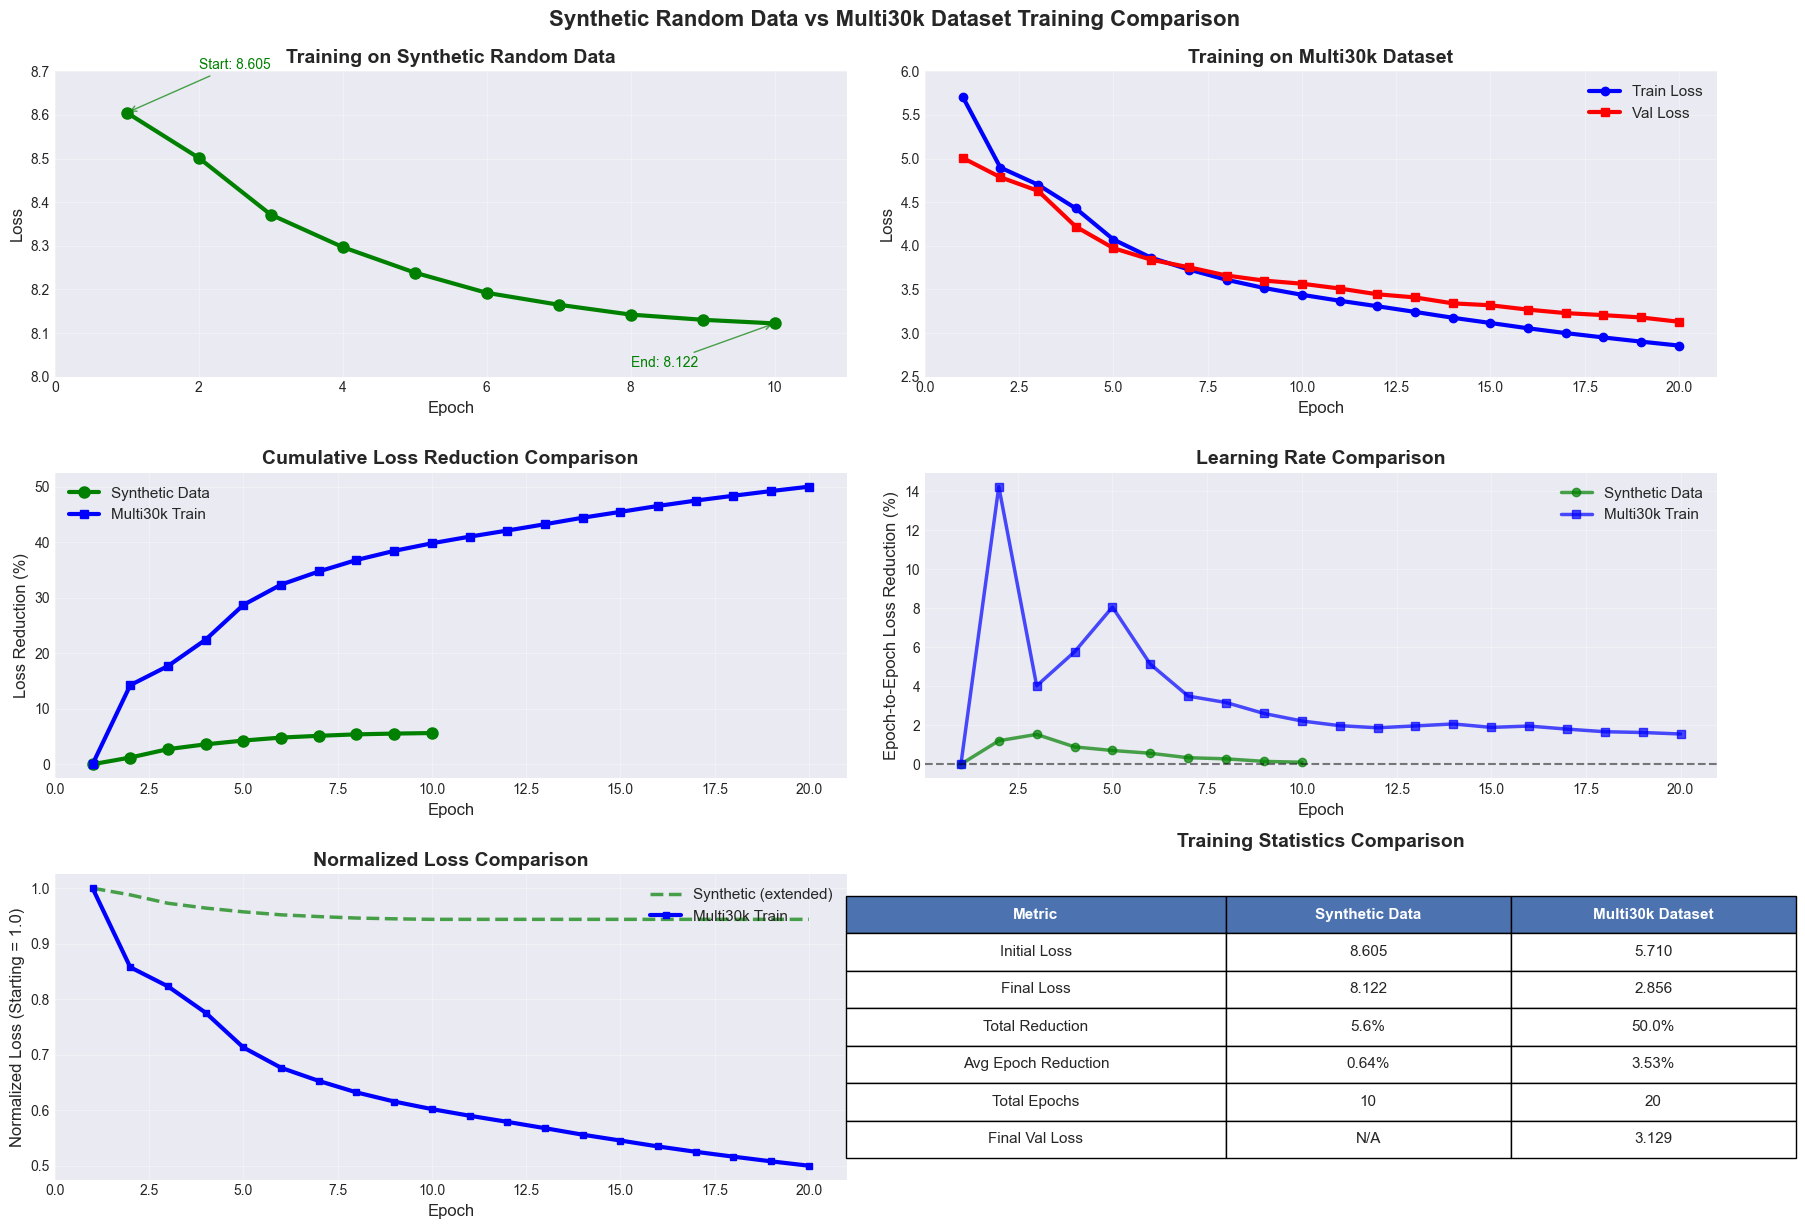

<Figure size 1200x800 with 0 Axes>

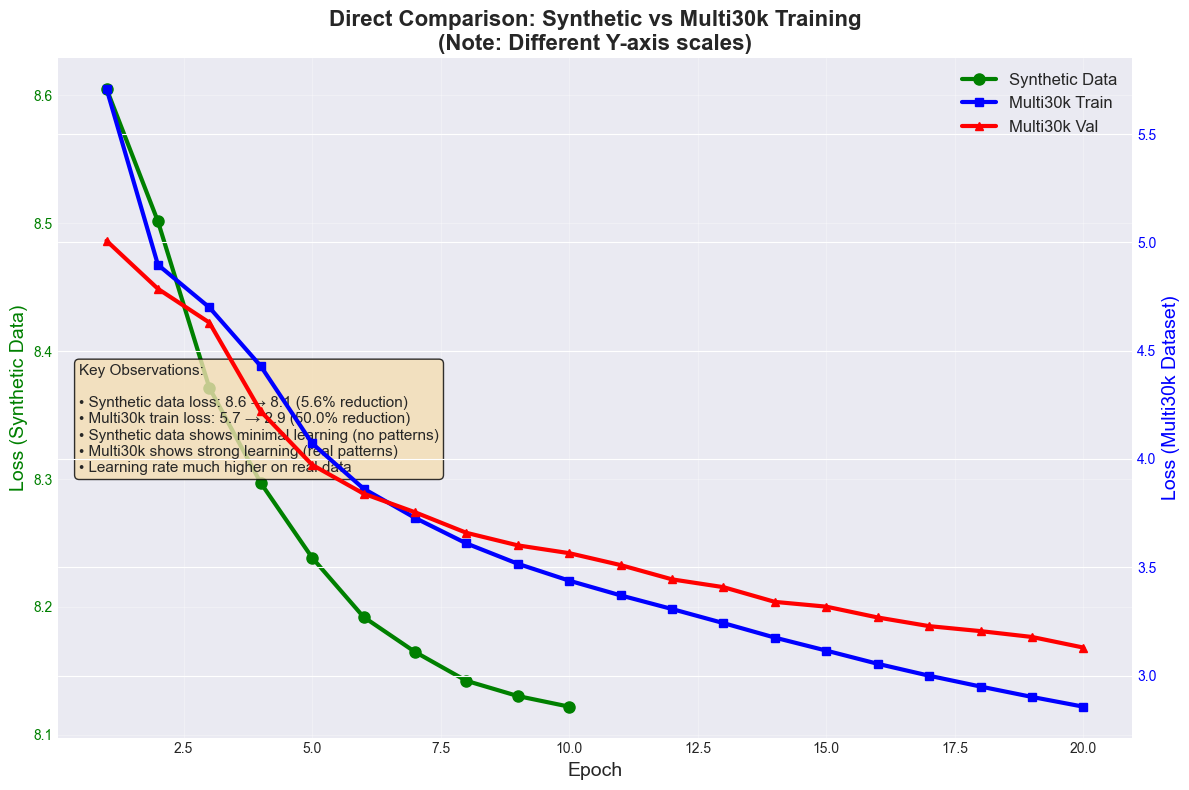

In [ ]:
#Visualization of Training Losses for Report

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Synthetic Random Data (10 epochs)
synthetic_epochs = list(range(1, 11))
synthetic_losses = [8.605189323425293, 8.501506805419922, 8.371408462524414, 8.296954154968262,
                   8.238499641418457, 8.192153930664062, 8.164850234985352, 8.142242431640625,
                   8.130334854125977, 8.122013092041016]

# Multi30k Dataset (20 epochs)
multi30k_epochs = list(range(1, 21))
multi30k_train_losses = [5.710, 4.897, 4.700, 4.429, 4.072, 3.863, 3.728, 3.610, 3.516, 3.438,
                        3.370, 3.307, 3.242, 3.175, 3.115, 3.054, 2.999, 2.949, 2.901, 2.856]
multi30k_val_losses = [5.008, 4.786, 4.630, 4.220, 3.973, 3.840, 3.754, 3.659, 3.601, 3.565,
                      3.510, 3.444, 3.408, 3.340, 3.318, 3.268, 3.228, 3.205, 3.178, 3.129]

# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# 1. Side-by-side comparison of both training runs
ax1 = plt.subplot(3, 2, 1)
ax1.plot(synthetic_epochs, synthetic_losses, 'g-', linewidth=3, label='Synthetic Data',
         marker='o', markersize=8)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training on Synthetic Random Data', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 11)
ax1.set_ylim(8.0, 8.7)

# Add annotations
ax1.annotate(f'Start: {synthetic_losses[0]:.3f}',
             xy=(1, synthetic_losses[0]),
             xytext=(2, synthetic_losses[0] + 0.1),
             arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
             fontsize=10, color='green')
ax1.annotate(f'End: {synthetic_losses[-1]:.3f}',
             xy=(10, synthetic_losses[-1]),
             xytext=(8, synthetic_losses[-1] - 0.1),
             arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
             fontsize=10, color='green')

# 2. Multi30k training
ax2 = plt.subplot(3, 2, 2)
ax2.plot(multi30k_epochs, multi30k_train_losses, 'b-', linewidth=3, label='Train Loss',
         marker='o', markersize=6)
ax2.plot(multi30k_epochs, multi30k_val_losses, 'r-', linewidth=3, label='Val Loss',
         marker='s', markersize=6)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Training on Multi30k Dataset', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 21)
ax2.set_ylim(2.5, 6)

# 3. Loss reduction comparison
ax3 = plt.subplot(3, 2, 3)

# Calculate percentage reduction for synthetic data
synthetic_reduction = [(synthetic_losses[0] - synthetic_losses[i])/synthetic_losses[0] * 100
                      for i in range(len(synthetic_losses))]
multi30k_reduction = [(multi30k_train_losses[0] - multi30k_train_losses[i])/multi30k_train_losses[0] * 100
                     for i in range(len(multi30k_train_losses))]

ax3.plot(synthetic_epochs, synthetic_reduction, 'g-', linewidth=3,
         label='Synthetic Data', marker='o', markersize=8)
ax3.plot(multi30k_epochs, multi30k_reduction, 'b-', linewidth=3,
         label='Multi30k Train', marker='s', markersize=6)

ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss Reduction (%)', fontsize=12)
ax3.set_title('Cumulative Loss Reduction Comparison', fontsize=14, fontweight='bold')
ax3.legend(loc='upper left', fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 21)

# 4. Learning rate comparison (epoch-to-epoch change)
ax4 = plt.subplot(3, 2, 4)

synthetic_epoch_reduction = [0] + [(synthetic_losses[i-1] - synthetic_losses[i])/synthetic_losses[i-1] * 100
                                  for i in range(1, len(synthetic_losses))]
multi30k_epoch_reduction = [0] + [(multi30k_train_losses[i-1] - multi30k_train_losses[i])/multi30k_train_losses[i-1] * 100
                                 for i in range(1, len(multi30k_train_losses))]

ax4.plot(synthetic_epochs, synthetic_epoch_reduction, 'g-', linewidth=2.5,
         label='Synthetic Data', marker='o', alpha=0.7)
ax4.plot(multi30k_epochs, multi30k_epoch_reduction, 'b-', linewidth=2.5,
         label='Multi30k Train', marker='s', alpha=0.7)

ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Epoch-to-Epoch Loss Reduction (%)', fontsize=12)
ax4.set_title('Learning Rate Comparison', fontsize=14, fontweight='bold')
ax4.legend(loc='upper right', fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 5. Normalized loss comparison (both starting from 1.0)
ax5 = plt.subplot(3, 2, 5)

synthetic_normalized = [loss / synthetic_losses[0] for loss in synthetic_losses]
multi30k_normalized = [loss / multi30k_train_losses[0] for loss in multi30k_train_losses]

# Extend synthetic data to 20 epochs for comparison (using last value)
synthetic_normalized_extended = synthetic_normalized + [synthetic_normalized[-1]] * 10
synthetic_epochs_extended = list(range(1, 21))

ax5.plot(synthetic_epochs_extended, synthetic_normalized_extended, 'g--', linewidth=2.5,
         label='Synthetic (extended)', alpha=0.7)
ax5.plot(multi30k_epochs, multi30k_normalized, 'b-', linewidth=3,
         label='Multi30k Train', marker='s', markersize=5)

ax5.set_xlabel('Epoch', fontsize=12)
ax5.set_ylabel('Normalized Loss (Starting = 1.0)', fontsize=12)
ax5.set_title('Normalized Loss Comparison', fontsize=14, fontweight='bold')
ax5.legend(loc='upper right', fontsize=11)
ax5.grid(True, alpha=0.3)
ax5.set_xlim(0, 21)

# 6. Summary statistics comparison
ax6 = plt.subplot(3, 2, 6)
ax6.axis('off')

# Calculate statistics
synthetic_stats = {
    'Dataset': 'Synthetic Random',
    'Initial Loss': f'{synthetic_losses[0]:.3f}',
    'Final Loss': f'{synthetic_losses[-1]:.3f}',
    'Total Reduction': f'{synthetic_reduction[-1]:.1f}%',
    'Avg Epoch Reduction': f'{np.mean(synthetic_epoch_reduction[1:]):.2f}%',
    'Epochs': 10
}

multi30k_stats = {
    'Dataset': 'Multi30k',
    'Initial Train Loss': f'{multi30k_train_losses[0]:.3f}',
    'Final Train Loss': f'{multi30k_train_losses[-1]:.3f}',
    'Total Reduction': f'{multi30k_reduction[-1]:.1f}%',
    'Avg Epoch Reduction': f'{np.mean(multi30k_epoch_reduction[1:]):.2f}%',
    'Final Val Loss': f'{multi30k_val_losses[-1]:.3f}',
    'Epochs': 20
}

# Create table
table_data = []
table_data.append(['Metric', 'Synthetic Data', 'Multi30k Dataset'])
table_data.append(['Initial Loss', synthetic_stats['Initial Loss'], multi30k_stats['Initial Train Loss']])
table_data.append(['Final Loss', synthetic_stats['Final Loss'], multi30k_stats['Final Train Loss']])
table_data.append(['Total Reduction', synthetic_stats['Total Reduction'], multi30k_stats['Total Reduction']])
table_data.append(['Avg Epoch Reduction', synthetic_stats['Avg Epoch Reduction'], multi30k_stats['Avg Epoch Reduction']])
table_data.append(['Total Epochs', str(synthetic_stats['Epochs']), str(multi30k_stats['Epochs'])])
table_data.append(['Final Val Loss', 'N/A', multi30k_stats['Final Val Loss']])

table = ax6.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# Style the header row
for i in range(3):
    table[(0, i)].set_facecolor('#4C72B0')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax6.set_title('Training Statistics Comparison', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
fig.suptitle('Synthetic Random Data vs Multi30k Dataset Training Comparison',
             fontsize=16, fontweight='bold', y=1.02)

# Create a focused comparison plot
plt.figure(figsize=(12, 8))

# Main comparison with both y-axes
fig2, ax_main = plt.subplots(figsize=(12, 8))

# Plot synthetic data on primary y-axis
color1 = 'green'
ax_main.set_xlabel('Epoch', fontsize=14)
ax_main.set_ylabel('Loss (Synthetic Data)', color=color1, fontsize=14)
line1 = ax_main.plot(synthetic_epochs, synthetic_losses, color=color1, linewidth=3,
                     label='Synthetic Data', marker='o', markersize=8)
ax_main.tick_params(axis='y', labelcolor=color1)
ax_main.grid(True, alpha=0.3)

# Create secondary y-axis for Multi30k data
ax_secondary = ax_main.twinx()
color2 = 'blue'
ax_secondary.set_ylabel('Loss (Multi30k Dataset)', color=color2, fontsize=14)
line2 = ax_secondary.plot(multi30k_epochs, multi30k_train_losses, color=color2, linewidth=3,
                          label='Multi30k Train', marker='s', markersize=6)
line3 = ax_secondary.plot(multi30k_epochs, multi30k_val_losses, 'r-', linewidth=3,
                          label='Multi30k Val', marker='^', markersize=6)
ax_secondary.tick_params(axis='y', labelcolor=color2)

# Add title and combine legends
ax_main.set_title('Direct Comparison: Synthetic vs Multi30k Training\n(Note: Different Y-axis scales)',
                  fontsize=16, fontweight='bold')

# Combine legends
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax_main.legend(lines, labels, loc='upper right', fontsize=12)

# Add text annotations for key insights
textstr = 'Key Observations:\n\n' \
          '• Synthetic data loss: 8.6 → 8.1 (5.6% reduction)\n' \
          '• Multi30k train loss: 5.7 → 2.9 (50.0% reduction)\n' \
          '• Synthetic data shows minimal learning (no patterns)\n' \
          '• Multi30k shows strong learning (real patterns)\n' \
          '• Learning rate much higher on real data'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax_main.text(0.02, 0.55, textstr, transform=ax_main.transAxes, fontsize=11,
             verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()
